In [73]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

In [74]:
%%bash
mkdir -p results
fusermount -uz results
sshfs compute.ies:/mnt/work/deep_al/results/active_learning results
ls results

CIFAR10
SVHN


In [91]:

def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results.json'
    exp_cfg = path / '.hydra' / 'config.yaml'
    exp_checkpoint = path / 'model_final.pth'
    try:
        cfg =  OmegaConf.load(exp_cfg)
        data = load_json(exp_json)
        checkpoint = torch.load(exp_checkpoint)
    except:
        print(f'{path} has missing results.')
        return

    results['cfg'] = cfg
    results['checkpoint'] = checkpoint
    results['results'] = data
    return results

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'results/CIFAR10/resnet18/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/'
exp_results = get_experiments(Path(path), 'seed1')
# metrics = get_metric_values(exp_results)
print(exp_results[0]['results']['cycle0'].keys())
print(exp_results[0]['results']['cycle0']['train_history'][-1].keys())
print(exp_results[0]['results']['cycle0']['test_stats'].keys())

dict_keys(['train_history', 'training_time', 'evaluation_time', 'test_stats', 'labeled_indices', 'n_labeled_samples', 'unlabeled_indices', 'n_unlabeled_samples'])
dict_keys(['test_acc1', 'test_prec', 'test_loss', 'test_nll', 'test_tce', 'test_mce'])
dict_keys(['train_lr', 'train_loss', 'train_acc1'])


## General Results

### Low Budget Domain

In [92]:
dataset = 'SVHN'
experiments = {}
# Deterministic
experiments.update({
    'random (Deterministic)': f'results/{dataset}/resnet18/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'uncertainty (Deterministic)': f'results/{dataset}/resnet18/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'badge (Deterministic)': f'results/{dataset}/resnet18/badge/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'coreset (Deterministic)': f'results/{dataset}/resnet18/coreset/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'random old hparams (Deterministic)': f'results/{dataset}/resnet18/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'uncertainty old hparams (Deterministic)': f'results/{dataset}/resnet18/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
})

# MC-Dropout
experiments.update({
    # 'random (MC-Dropout)': f'results/{dataset}/resnet18_mcdropout/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'uncertainty (MC-Dropout)': f'results/{dataset}/resnet18_mcdropout/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
})

# Ensemble
experiments.update({
    # 'random (Ensemble)': f'results/{dataset}/resnet18_ensemble/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'uncertainty (Ensemble)': f'results/{dataset}/resnet18_ensemble/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
})

# Eval Model
experiments.update({
    # 'deterministic random queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_random_queries/',
    # 'deterministic uncertainty queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_uncertainty_queries/',
    # 'mcdropout uncertainty queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_mcdropout_uncertainty_queries/',
    # 'ensemble uncertainty queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_ensemble_uncertainty_queries/',
})


all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

  0%|          | 0/4 [00:00<?, ?it/s]


AssertionError: No experiments found for results/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ9.

100%|██████████| 4/4 [00:00<00:00, 39.42it/s]


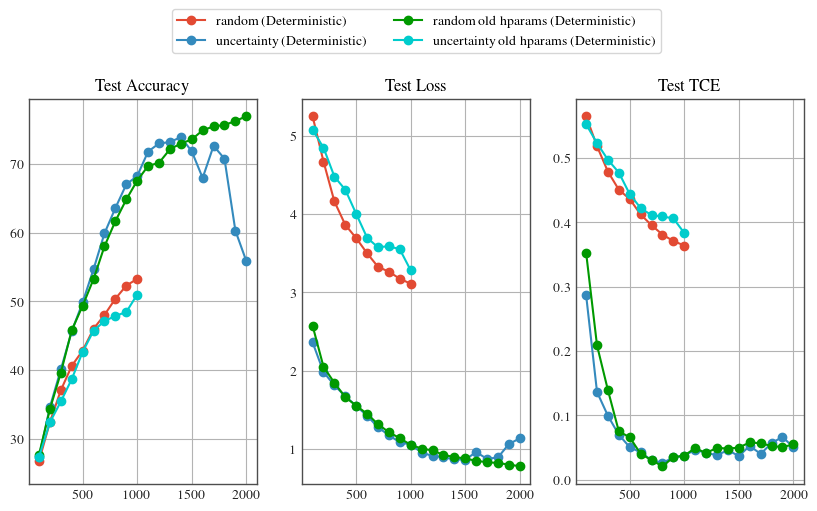

In [89]:
show_std = True
for strat_name, results in tqdm(all_results.items()):

    train_accs = []
    train_loss = []
    test_accs = []
    test_nll = []
    test_tce = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        train_accs.append([data[cycle]['train_history'][-1]['train_acc1'] for cycle in data])
        train_loss.append([data[cycle]['train_history'][-1]['train_loss'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['test_acc1'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['test_nll'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['test_tce'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    train_accs_mean, train_accs_std = np.mean(train_accs, 0), np.std(train_accs, 0)
    train_loss_mean, train_loss_std = np.mean(train_loss, 0), np.std(train_loss, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)

    plt.subplot(131)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-o', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean-test_accs_std, alpha=.3)
    plt.subplot(132)
    plt.title('Test Loss')
    plt.plot(n_labeled_samples, test_nll_mean, '-o', label=strat_name)
    plt.subplot(133)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-o', label=strat_name)

plt.subplot(132).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        

### High Budget Domain

#### CIFAR10

In [ ]:
high_budget_experiments = {
    # Deterministic ResNet18
    'random_det': f'results/CIFAR10/resnet18/random/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    'uncertainty_det': f'results/CIFAR10/resnet18/uncertainty/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    'coreset_det': f'results/CIFAR10/resnet18/coreset/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    'badge_det': f'results/CIFAR10/resnet18/badge/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    'predefined_det': f'results/CIFAR10/resnet18/predefined/resnet18_uncertainty/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    ## SNGP ResNet18
    # 'random_sngp': f'results/CIFAR10/resnet18_sngp/random/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    # 'uncertainty_sngp': f'results/CIFAR10/resnet18_sngp/uncertainty/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    # 'coreset_sngp': f'results/CIFAR10/resnet18_sngp/coreset/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    ## MISC
    # 'resnet18_high_lr': f'results/CIFAR10/resnet18/uncertainty/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{n_acq}__lr0.1/',
    # 'random': f'results/CIFAR10/resnet18/random/N_INIT{2000}__ACQ_SIZE{2000}__N_ACQ{4}/',
}

results = {}
for exp_name, exp_path in tqdm(high_budget_experiments.items()):
    exp_results = get_experiments(Path(exp_path), 'seed*')
    metrics = get_metric_values(exp_results)
    results[exp_name] = metrics

In [ ]:
show_std = False
for strat_name, metrics in results.items():
    n_labeled_samples = np.mean(metrics['n_labeled_samples'], axis=0)
    acc = np.mean(metrics['test_acc1'], axis=0)
    acc_std = np.std(metrics['test_acc1'], axis=0)
    plt.plot(n_labeled_samples, acc, label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, acc - acc_std, acc+acc_std, alpha=.3)
    plt.legend()

#### SVHN

In [ ]:
high_budget_experiments = {
    # Deterministic ResNet18
    'random_det': f'results/SVHN/resnet18/random/N_INIT{500}__ACQ_SIZE{500}__N_ACQ{10}/',
    'uncertainty_det': f'results/SVHN/resnet18/uncertainty/N_INIT{500}__ACQ_SIZE{500}__N_ACQ{10}/',
    'badge_det': f'results/SVHN/resnet18/badge/N_INIT{500}__ACQ_SIZE{500}__N_ACQ{10}/',
    # 'coreset_det': f'results/SVHN/resnet18/coreset/N_INIT{500}__ACQ_SIZE{500}__N_ACQ{10}/',
    ## SNGP ResNet18
    # 'random_sngp': f'results/SVHN/resnet18_sngp/random/N_INIT{500}__ACQ_SIZE{1000}__N_ACQ{10}/',
    # 'uncertainty_sngp': f'results/SVHN/resnet18_sngp/uncertainty/N_INIT{500}__ACQ_SIZE{1000}__N_ACQ{10}/',
    # 'coreset_sngp': f'results/SVHN/resnet18_sngp/coreset/N_INIT{500}__ACQ_SIZE{1000}__N_ACQ{10}/',
    ## MISC
    # 'resnet18_high_lr': f'results/SVHN/resnet18/uncertainty/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{n_acq}__lr0.1/',
    # 'random': f'results/SVHN/resnet18/random/N_INIT{2000}__ACQ_SIZE{2000}__N_ACQ{4}/',
}

results = {}
for exp_name, exp_path in tqdm(high_budget_experiments.items()):
    exp_results = get_experiments(Path(exp_path), 'seed*')
    metrics = get_metric_values(exp_results)
    results[exp_name] = metrics

In [ ]:
show_std = False 
for strat_name, metrics in results.items():
    n_labeled_samples = np.mean(metrics['n_labeled_samples'], axis=0)
    acc = np.mean(metrics['test_acc1'], axis=0)
    acc_std = np.std(metrics['test_acc1'], axis=0)
    plt.plot(n_labeled_samples, acc, label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, acc - acc_std, acc+acc_std, alpha=.3)
    plt.legend()

In [ ]:
from torchvision.datasets import CIFAR10

path = Path(high_budget_experiments['coreset'])

dataset = CIFAR10('/tmp', train=True, download=True)
exp_results = get_experiments(path, 'seed*')
for i in range(10):
    cycle = f'cycle{i}'

    classes = []
    classes_count = []
    for seed_result in exp_results:
        if seed_result is None:
            continue
        sampled_classes_seed = []
        labeled_indices_seed = seed_result['results'][cycle]['labeled_indices']
        for idx in labeled_indices_seed:
            _, lbl = dataset[idx]
            sampled_classes_seed.append(lbl)
        classes_seed, classes_count_seed  = np.unique(sampled_classes_seed, return_counts=True)
        classes.append(classes_seed)
        classes_count.append(classes_count_seed)

    classes = np.array(classes)
    classes_count = np.array(classes_count)
    plt.bar(np.mean(classes, axis=0), np.mean(classes_count, axis=0))
    plt.xticks(np.mean(classes, axis=0), dataset.classes, rotation=45)
    plt.show()
    # plt.bar(*np.unique(sampeled_classes, return_counts=True))

In [ ]:
experiment_results = exp_results[0]['results']
for key in experiment_results:
    cycle_stats = experiment_results[key]
    train_history = cycle_stats['train_history']

    fig = plt.figure()
    fig.suptitle('Train samples: %s' % cycle_stats['n_labeled_samples'])
    plt.subplot(121)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot([d['train_loss'] for d in train_history])

    plt.subplot(122)
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.plot([d['train_acc1'] for d in train_history])
    plt.show()